<a href="https://colab.research.google.com/github/beckman9191/ECE1513-Introduction-to-Machine-Learning/blob/main/ECE1513_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   **Name**: Zhengnan Zhu
*   **Student number**: 1005209971
*   **URL**: https://colab.research.google.com/drive/1lmkz_XxzibU-oSyACfcnCSCD87zd7vIF#scrollTo=hCRKDbmVZsDW

In [ ]:
#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uciml/indian-liver-patient-records

indian-liver-patient-records.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_name = 'indian-liver-patient-records.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#3)

def load_and_split_data(file_path):
  df=pd.read_csv(file_path)
  df=df.fillna(0)

  y=df['Dataset'].astype(float)
  X=df.drop(['Dataset'], axis=1)
  X['Gender']=np.where(X['Gender']=='Male',1,0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  return X_train, X_test, y_train, y_test

filepath = 'indian_liver_patient.csv'
X_train, X_test, y_train, y_test = load_and_split_data(filepath)




In [ ]:
# Create a standard scaler object
scaler=StandardScaler()
scaler.fit(X_train)

X_train_standardized=scaler.transform(X_train)
X_test_standardized=scaler.transform(X_test)


# Create a min-max scaler object for X
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)


X_train_normalized=minmax_scaler.transform(X_train)
X_test_normalized=minmax_scaler.transform(X_test)

X_train=X_train.to_numpy()
X_test=X_test.to_numpy()

# Create a min-max scaler object for Y
minmax_scaler_y = MinMaxScaler()
minmax_scaler_y.fit(y_train.to_numpy().reshape(-1, 1))
y_train_normalized=minmax_scaler_y.transform(y_train.to_numpy().reshape(-1, 1))
y_test_normalized=minmax_scaler_y.transform(y_test.to_numpy().reshape(-1, 1))





In [ ]:
#4)
#set parameters
input_size=X_train_normalized.shape[1]
output_size=1

class FullyConnectedNeuralNetwork(nn.Module):
  def __init__(self, input_size, layer_lst, output_size):
    super().__init__() #instantiate nn.Module

    size=len(layer_lst)
    self.input_size=input_size
    self.output_size=output_size
    self.num_hidden_layers=size
    self.layer_lst=layer_lst

    self.relu=nn.ReLU()
    self.sigmoid=nn.Sigmoid()

    #input to the first hidden layer
    self.fc_layers=nn.ModuleList([
        nn.Linear(input_size, layer_lst[0])
    ])

    #between hidden layer
    for i in range(0, size-1):
      self.fc_layers.append(nn.Linear(layer_lst[i], layer_lst[i+1]))

    #hidden to output layer
    self.fc_layers.append(nn.Linear(layer_lst[size-1], output_size))


  def forward(self, x):

    for layer in self.fc_layers[:-1]:
      x=self.relu(layer(x))

    x=self.sigmoid(self.fc_layers[-1](x))

    return x.float()



In [ ]:
#5a)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score
def train_and_evaluate(layer_lst, X_train, y_train, X_test, y_test, num_epochs=500):
  input_size=X_train_normalized.shape[1]
  output_size=1

  X_train_tensor=torch.FloatTensor(X_train)
  X_test_tensor=torch.FloatTensor(X_test)
  y_train_tensor=torch.FloatTensor(y_train)
  y_test_tensor=torch.FloatTensor(y_test)

  #---------------building the model, set the loss function and the optimizer---------------
  #create the model
  model=FullyConnectedNeuralNetwork(input_size, layer_lst, output_size)


  #Loss function: binary cross entropy
  criterion=nn.BCELoss()

  #Adam optimizer
  optimizer=optim.Adam(model.parameters(), lr=0.001)


  #------------------------train------------------------
  for epoch in range(num_epochs):
    outputs=model(X_train_tensor)
    loss=criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



  #------------------------evaluate------------------------
  model.eval()

  with torch.no_grad():
    y_pred_train=model(X_train_tensor)
    y_pred_train=(y_pred_train>=0.5).float()
    train_accuracy=accuracy_score(y_train_normalized, y_pred_train)
    #print(accuracy)
    train_f1=f1_score(y_train_normalized, y_pred_train)
    #print(f1)



    y_pred_test=model(X_test_tensor)
    y_pred_test=(y_pred_test>=0.5).float()
    test_accuracy=accuracy_score(y_test_normalized, y_pred_test)
    #print(accuracy)
    test_f1=f1_score(y_test_normalized, y_pred_test)
    #print(f1)





  return train_accuracy, train_f1, test_accuracy, test_f1


In [ ]:
combinations=[
        [128],
        [64],
        [32],
        [128, 128],
        [128, 64],
        [128, 32],
        [64, 128],
        [64, 64],
        [64, 32],
        [32, 128],
        [32, 64],
        [32, 32],
        [128, 128, 128],
        [128, 128, 64],
        [128, 128, 32],
        [128, 64, 128],
        [128, 64, 64],
        [128, 64, 32],
        [128, 32, 128],
        [128, 32, 64],
        [128, 32, 32],

        [64, 128, 128],
        [64, 128, 64],
        [64, 128, 32],
        [64, 64, 128],
        [64, 64, 64],
        [64, 64, 32],
        [64, 32, 128],
        [64, 32, 64],
        [64, 32, 32],

        [32, 128, 128],
        [32, 128, 64],
        [32, 128, 32],
        [32, 64, 128],
        [32, 64, 64],
        [32, 64, 32],
        [32, 32, 128],
        [32, 32, 64],
        [32, 32, 32]
]

best_accuracy = 0
best_f1_score = 0
best_architecture = None


training_accuracies=[]
training_f1_scores=[]

testing_accuracies=[]
testing_f1_scores=[]

for comb in combinations:
  print(comb)
  training_accuracy, training_f1, test_accuracy, test_f1=train_and_evaluate(comb, X_train, y_train_normalized, X_test, y_test_normalized, 500)
  print(f"the testing accuracy for {comb} is {test_accuracy}")
  print(f"the testing f1 score for {comb} is {test_f1}")

  training_accuracies.append(training_accuracy)
  training_f1_scores.append(training_f1)

  testing_accuracies.append(test_accuracy)
  testing_f1_scores.append(test_f1)

  if testing_accuracies[-1] > best_accuracy:
      best_accuracy = testing_accuracies[-1]
      best_f1_score = testing_f1_scores[-1]
      best_architecture = comb


# Report the best architecture and its performance
print(f"Best architecture: {best_architecture}")
print(f"Best testing accuracy: {best_accuracy}")
print(f"Best testing F1 score: {best_f1_score}")





[128]
the testing accuracy for [128] is 0.6857142857142857
the testing f1 score for [128] is 0.22535211267605634
[64]
the testing accuracy for [64] is 0.6571428571428571
the testing f1 score for [64] is 0.16666666666666666
[32]
the testing accuracy for [32] is 0.6971428571428572
the testing f1 score for [32] is 0.25352112676056343
[128, 128]
the testing accuracy for [128, 128] is 0.6685714285714286
the testing f1 score for [128, 128] is 0.3695652173913044
[128, 64]
the testing accuracy for [128, 64] is 0.6628571428571428
the testing f1 score for [128, 64] is 0.3058823529411765
[128, 32]
the testing accuracy for [128, 32] is 0.7085714285714285
the testing f1 score for [128, 32] is 0.38554216867469876
[64, 128]
the testing accuracy for [64, 128] is 0.7142857142857143
the testing f1 score for [64, 128] is 0.35897435897435903
[64, 64]
the testing accuracy for [64, 64] is 0.6685714285714286
the testing f1 score for [64, 64] is 0.3095238095238095
[64, 32]
the testing accuracy for [64, 32] is

In [ ]:
#5a continue)
def train_and_test(best_model, input_size, X_train, y_train, X_test, y_test, num_epoch=500, lr=0.001):

  output_size=1

  X_train_tensor=torch.FloatTensor(X_train)
  X_test_tensor=torch.FloatTensor(X_test)
  y_train_tensor=torch.FloatTensor(y_train)
  y_test_tensor=torch.FloatTensor(y_test)

  training_accuracies_best=[]
  testing_accuracies_best=[]
  training_f1_best=[]
  testing_f1_best=[]
  #---------------building the model, set the loss function and the optimizer---------------
  #create the model
  model=FullyConnectedNeuralNetwork(input_size, best_model, output_size)


  #Loss function: binary cross entropy
  criterion=nn.BCELoss()

  #Adam optimizer
  optimizer=optim.Adam(model.parameters(), lr=lr)

  num_epochs = 500
  for epoch in range(num_epochs):
      # Forward pass
      outputs = model(X_train_tensor)
      loss = criterion(outputs, y_train_tensor)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

      with torch.no_grad():
        y_pred_train=model(X_train_tensor)
        y_pred_train=(y_pred_train>=0.5).float()
        train_accuracy=accuracy_score(y_train, y_pred_train)
        training_accuracies_best.append(train_accuracy)
        train_f1=f1_score(y_train, y_pred_train)
        training_f1_best.append(train_f1)



        y_pred_test=model(X_test_tensor)
        y_pred_test=(y_pred_test>=0.5).float()
        test_accuracy=accuracy_score(y_test, y_pred_test)
        testing_accuracies_best.append(test_accuracy)
        test_f1=f1_score(y_test, y_pred_test)
        testing_f1_best.append(test_f1)


  # Plot the training and testing accuracy and F1-score
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  axes[0].plot(range(num_epochs), training_accuracies_best, label='training accuracies')
  axes[0].plot(range(num_epochs), testing_accuracies_best, label='testing accuracies')
  axes[0].set_xlabel('num_epochs')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_title('Accuracy')
  axes[0].legend()

  axes[1].plot(range(num_epochs), training_f1_best, label='training f1 scores')
  axes[1].plot(range(num_epochs), testing_f1_best, label='testing f1 scores')
  axes[1].set_xlabel('num_epochs')
  axes[1].set_ylabel('f1 scores')
  axes[1].set_title('f1 scores')
  axes[1].legend()

  # Adjust layout
  plt.tight_layout()

  # Display the subplots
  plt.show()

  return model

Epoch [100/500], Loss: 0.5178
Epoch [200/500], Loss: 0.4884
Epoch [300/500], Loss: 0.4634
Epoch [400/500], Loss: 0.4488
Epoch [500/500], Loss: 0.4409


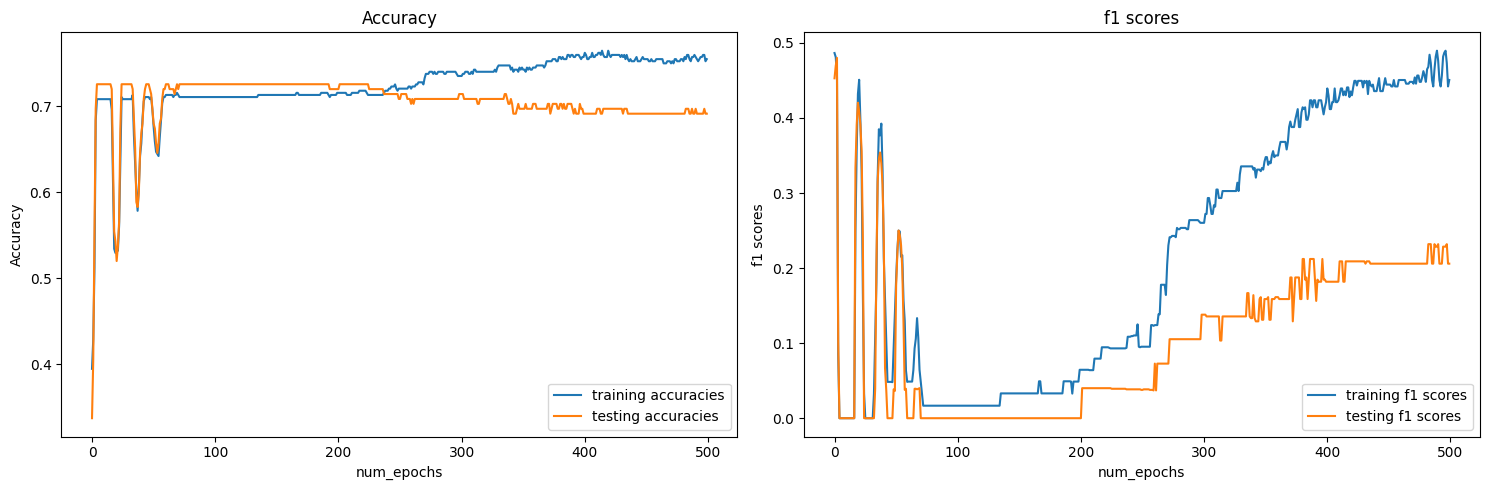

In [ ]:
#5a continue)
my_5a=train_and_test(best_architecture, X_train_normalized.shape[1], X_train, y_train_normalized, X_test, y_test_normalized, 500, 0.001)

**Analysis of Different Architectures:**

I explored various combinations of neurons and layers, as outlined in the predefined list. Despite the diversity in architectures, the testing accuracy consistently fell within the range of 0.60 to 0.70. Concurrently, the testing F1 score exhibited values around 0.30 to 0.40.

**Lack of Significant Differences:**

Interestingly, the testing accuracies did not show substantial variations across the diverse architectures, even after 500 epochs of training. The testing accuracy remained relatively consistent regardless of the specific neural network configuration.

**Does deep learning worth it in this case?**

Given the observed results, I think it is not necessary to do the deep learning as the limited disparity in testing accuracy acorss different architectures indicates that a more complex model might not be providing significant advantages over simpler ones.

Epoch [100/500], Loss: 0.5438
Epoch [200/500], Loss: 0.5025
Epoch [300/500], Loss: 0.4895
Epoch [400/500], Loss: 0.4798
Epoch [500/500], Loss: 0.4682


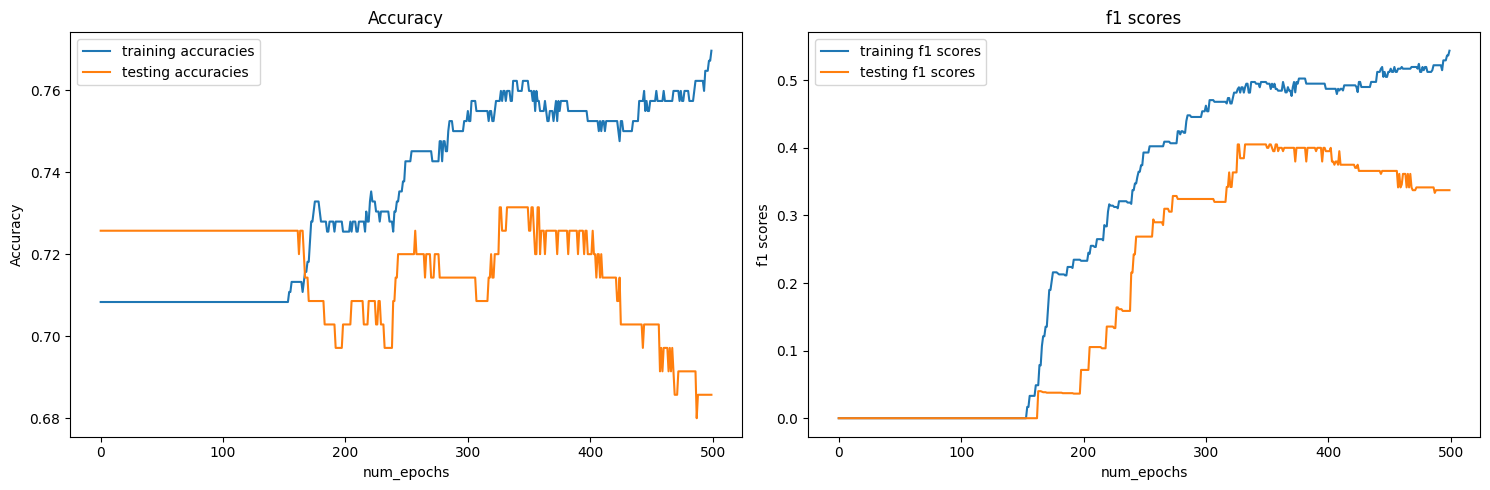

Epoch [100/500], Loss: 0.4792
Epoch [200/500], Loss: 0.4077
Epoch [300/500], Loss: 0.3197
Epoch [400/500], Loss: 0.2395
Epoch [500/500], Loss: 0.1834


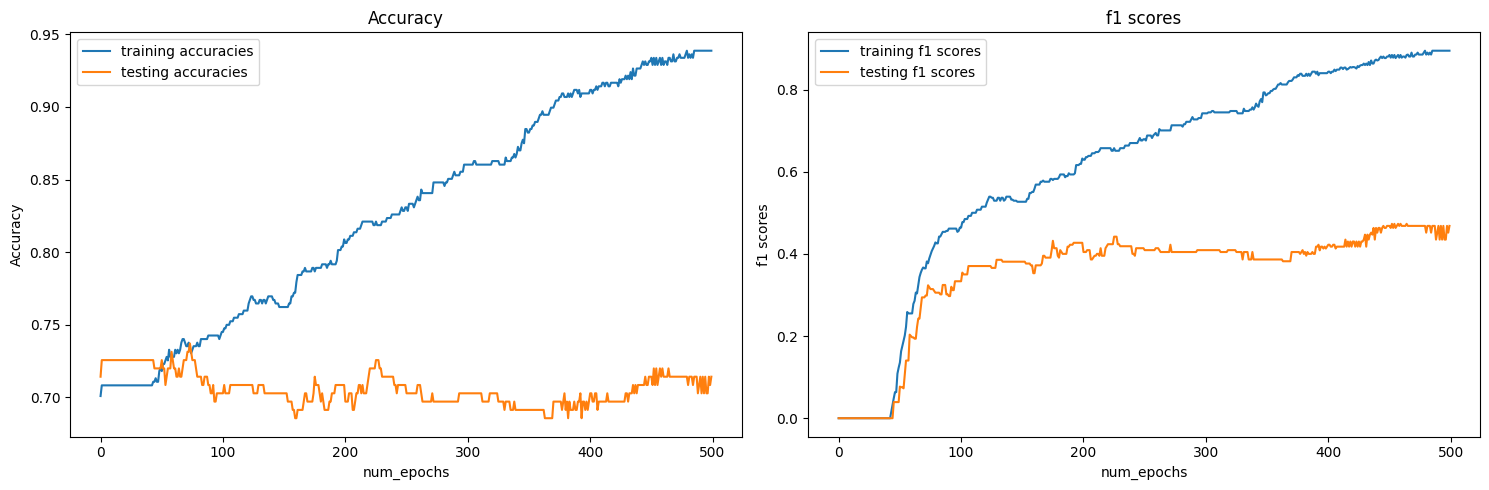

In [ ]:
#5b)
my_5b_normalized=train_and_test(best_architecture, X_train_normalized.shape[1], X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized, 500, 0.001)
my_5b_standardized=train_and_test(best_architecture, X_train_normalized.shape[1], X_train_standardized, y_train_normalized, X_test_standardized, y_test_normalized, 500, 0.001)

For the normalized data, the training/testing accuracy and training/testing f1 scores remain unchanged for the first 150 epochs. The training accuracy is increasing afterwards while the testing accuracy is fluctuate around .70.

For the standardized data, the training accuracy approaches to 1 after 500 epochs of training, which lead to overfitting issue.

I prefer using the original data as the result is more stable.

Epoch [100/500], Loss: 29.1667
Epoch [200/500], Loss: 29.1667
Epoch [300/500], Loss: 29.1667
Epoch [400/500], Loss: 29.1667
Epoch [500/500], Loss: 29.1667


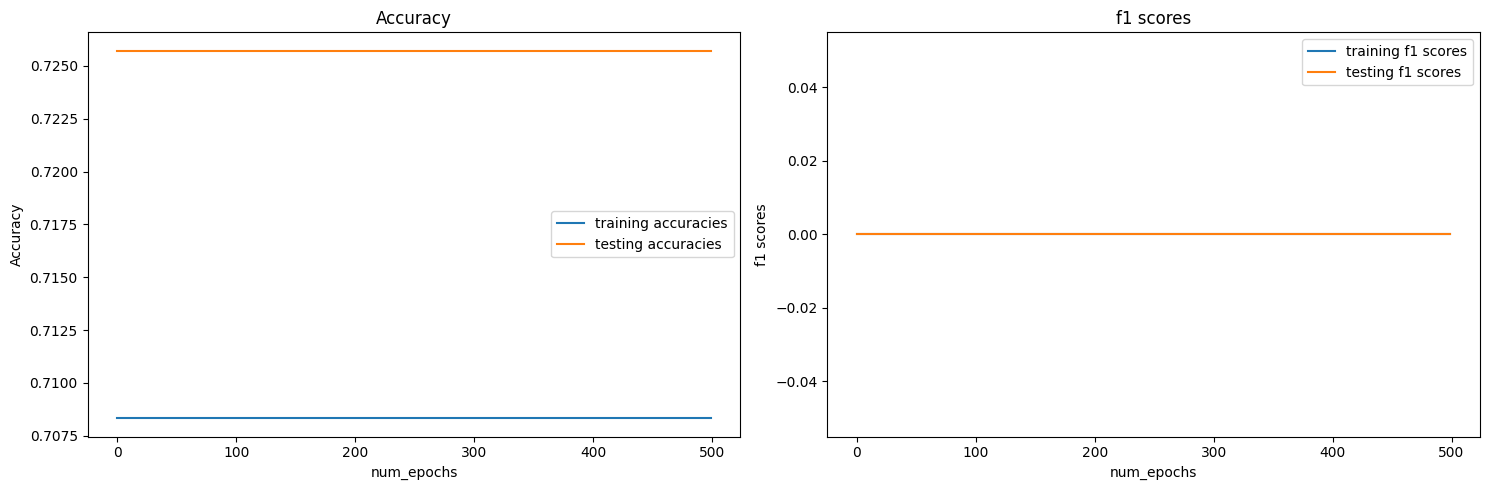

Epoch [100/500], Loss: 1.4646
Epoch [200/500], Loss: 1.2151
Epoch [300/500], Loss: 1.1699
Epoch [400/500], Loss: 1.1277
Epoch [500/500], Loss: 1.0883


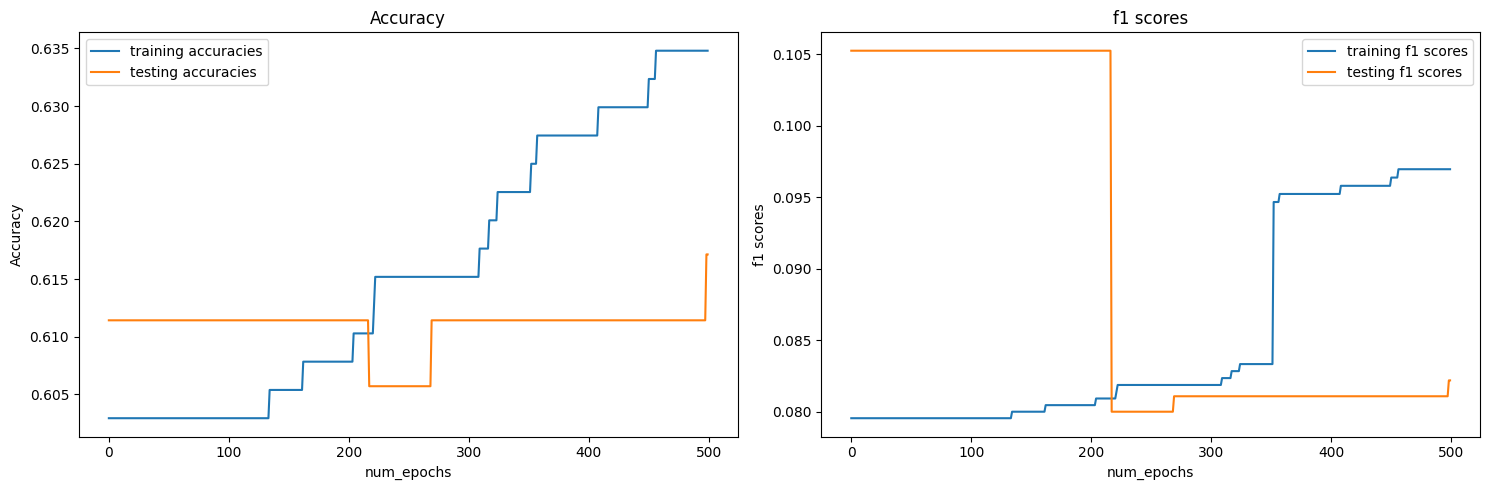

In [ ]:
#5c)
my_5c_lr_01=train_and_test(best_architecture, X_train_normalized.shape[1], X_train, y_train_normalized, X_test, y_test_normalized, 500, 0.1)
my_5c_lr_0000001=train_and_test(best_architecture, X_train_normalized.shape[1], X_train, y_train_normalized, X_test, y_test_normalized, 500, 0.000001)

0.1 learning rate leads to a significantly high loss and the loss diverges. The advantage is that it can lead to faster convergence during training. The disadvantages involves overshooting, instability, skipping the minimum and loss divergence issue.

0.000001 learning rate leads to a relatively lower loss. The advantages include stability, fine-tuning and avoid divergence. The disadvantages include slow convergence issue and it may get stuck in local minima.

In [ ]:
#5c cont)
import torch.optim.lr_scheduler as lr_scheduler
def train_and_test_with_scheduler(best_model, input_size, X_train, y_train, X_test, y_test, num_epoch=500):
  input_size=X_train_normalized.shape[1]
  output_size=1

  X_train_tensor=torch.FloatTensor(X_train)
  X_test_tensor=torch.FloatTensor(X_test)
  y_train_tensor=torch.FloatTensor(y_train)
  y_test_tensor=torch.FloatTensor(y_test)

  training_accuracies_best=[]
  testing_accuracies_best=[]
  training_f1_best=[]
  testing_f1_best=[]
  #---------------building the model, set the loss function and the optimizer---------------
  #create the model
  model=FullyConnectedNeuralNetwork(input_size, best_model, output_size)


  #Loss function: binary cross entropy
  criterion=nn.BCELoss()

  #Adam optimizer
  optimizer=optim.Adam(model.parameters(), lr=0.001)
  scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

  for epoch in range(num_epoch):
      # Forward pass
      outputs = model(X_train_tensor)
      loss = criterion(outputs, y_train_tensor)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      before_lr = optimizer.param_groups[0]["lr"]
      scheduler.step()
      after_lr = optimizer.param_groups[0]["lr"]
      #print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}')

      with torch.no_grad():
        y_pred_train=model(X_train_tensor)
        y_pred_train=(y_pred_train>=0.5).float()
        train_accuracy=accuracy_score(y_train, y_pred_train)
        training_accuracies_best.append(train_accuracy)
        train_f1=f1_score(y_train, y_pred_train)
        training_f1_best.append(train_f1)



        y_pred_test=model(X_test_tensor)
        y_pred_test=(y_pred_test>=0.5).float()
        test_accuracy=accuracy_score(y_test, y_pred_test)
        testing_accuracies_best.append(test_accuracy)
        test_f1=f1_score(y_test, y_pred_test)
        testing_f1_best.append(test_f1)


  # Plot the training and testing accuracy and F1-score
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  axes[0].plot(range(num_epoch), training_accuracies_best, label='training accuracies')
  axes[0].plot(range(num_epoch), testing_accuracies_best, label='testing accuracies')
  axes[0].set_xlabel('num_epochs')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_title('Accuracy')
  axes[0].legend()

  axes[1].plot(range(num_epoch), training_f1_best, label='training f1 scores')
  axes[1].plot(range(num_epoch), testing_f1_best, label='testing f1 scores')
  axes[1].set_xlabel('num_epochs')
  axes[1].set_ylabel('f1 scores')
  axes[1].set_title('f1 scores')
  axes[1].legend()

  # Adjust layout
  plt.tight_layout()

  # Display the subplots
  plt.show()

Epoch [100/500], Loss: 0.5086
Epoch [200/500], Loss: 0.4818
Epoch [300/500], Loss: 0.4652
Epoch [400/500], Loss: 0.4516
Epoch [500/500], Loss: 0.4395


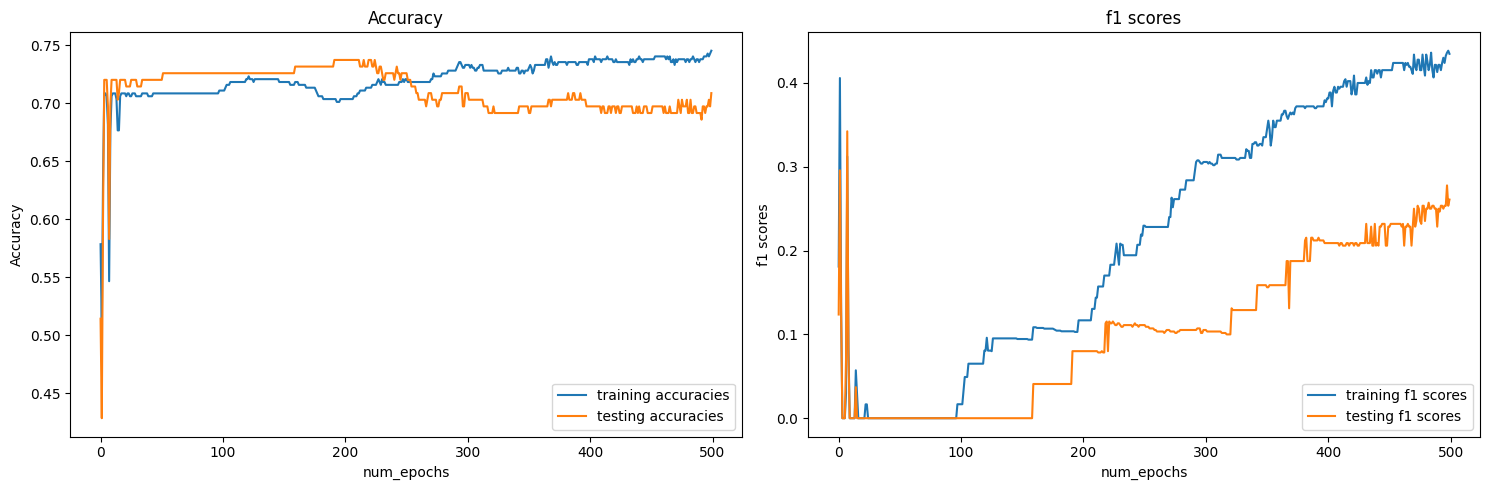

In [ ]:
#5c cont)
my_5c_scheduler=train_and_test_with_scheduler(best_architecture, X_train_normalized.shape[1], X_train, y_train_normalized, X_test, y_test_normalized, 500)


The learning rate schedular leads to a significantly lower loss and it can find the optimal learning rate that avoid the disadvantages of fixed learning rate. However, it increase the complexity of the model and require an apropriate schedule.

Epoch [100/500], Loss: 0.5737
Epoch [200/500], Loss: 0.5249
Epoch [300/500], Loss: 0.4956
Epoch [400/500], Loss: 0.4670
Epoch [500/500], Loss: 0.4422


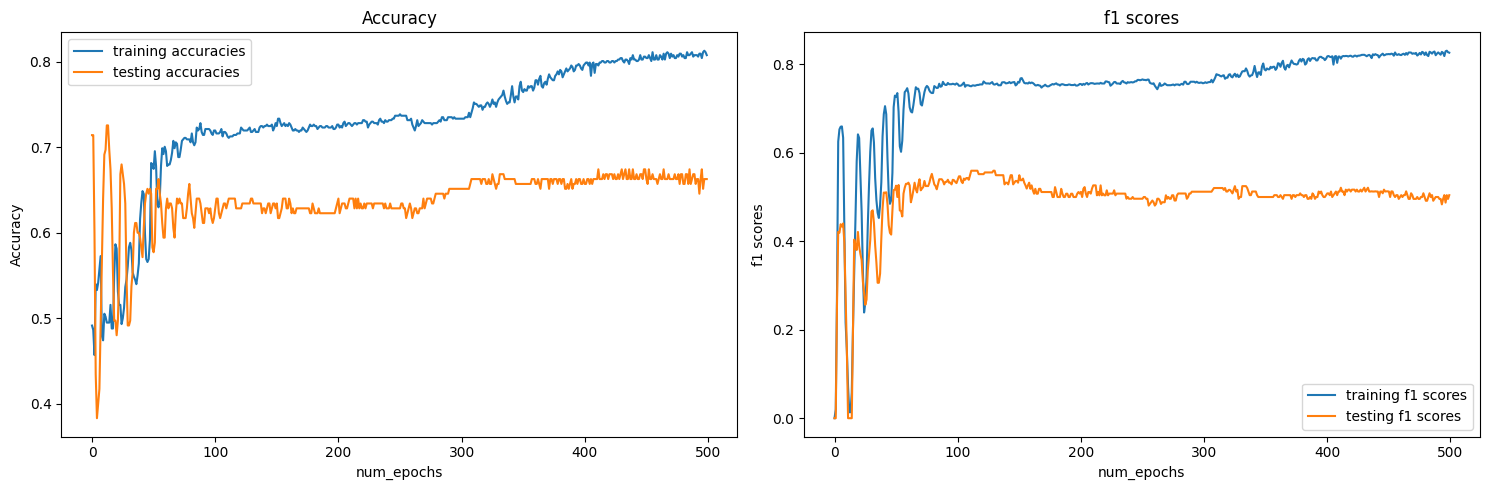

Epoch [100/500], Loss: 0.5792
Epoch [200/500], Loss: 0.5547
Epoch [300/500], Loss: 0.5396
Epoch [400/500], Loss: 0.5240
Epoch [500/500], Loss: 0.5073


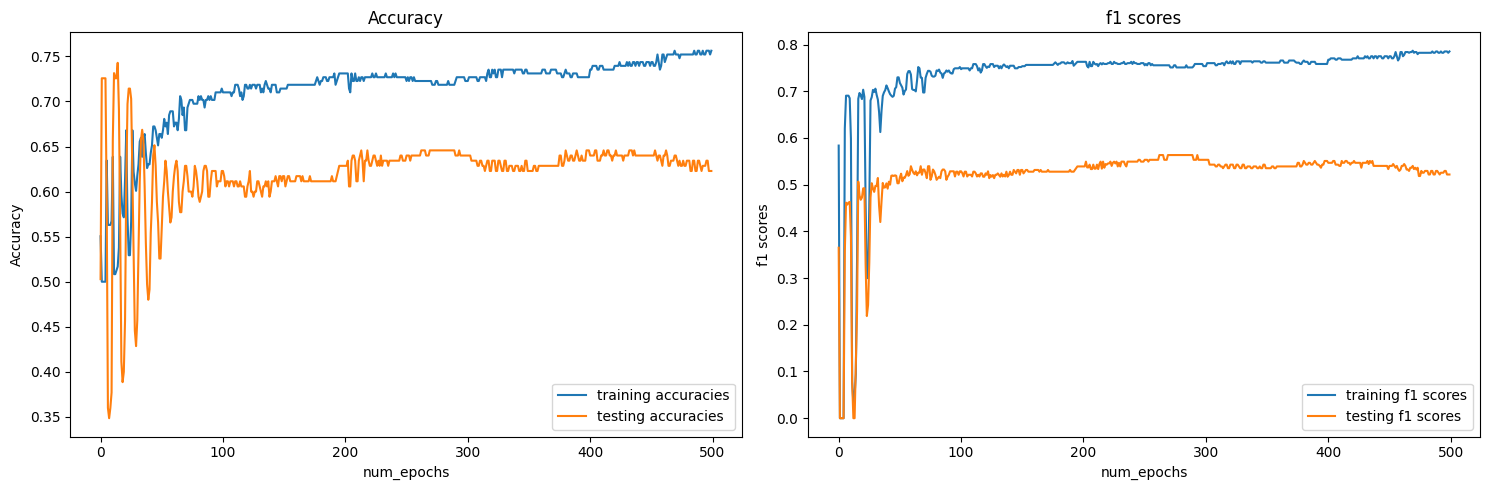

In [ ]:
#5d)
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

# Function to balance the training set using SMOTE
def oversample_smote(X_train, y_train):
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Function to balance the training set using random undersampling
def undersample_random(X_train, y_train):
    random_undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = random_undersampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Balance the training set using SMOTE
X_train_smote, y_train_smote = oversample_smote(X_train, y_train)
y_train_smote_normalized=minmax_scaler_y.transform(y_train_smote.to_numpy().reshape(-1, 1))

# Balance the training set using random undersampling
X_train_random, y_train_random = undersample_random(X_train, y_train)
y_train_random_normalized=minmax_scaler_y.transform(y_train_random.to_numpy().reshape(-1, 1))

# Train and test the model with the balanced training set using SMOTE
smote = train_and_test(best_architecture, X_train_normalized.shape[1], X_train_smote, y_train_smote_normalized, X_test, y_test_normalized, lr=0.001)
# Train and test the model with the balanced training set using random undersampling
random = train_and_test(best_architecture, X_train_normalized.shape[1], X_train_random, y_train_random_normalized, X_test, y_test_normalized, lr=0.001)


Both techniques shows the similar graph for the accuracy and f1 scores. The value fluctuate a lot for the first couples of epochs. Both training accuracy and f1 scores have an upward trend before 150 epochs and they become relatively stable afterwards.

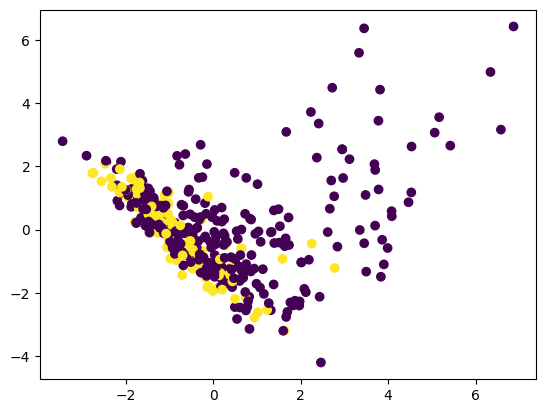

In [ ]:
#5e
import sklearn.linear_model
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_train_standardized_pca = pca.fit_transform(X_train_standardized)
X_test_standardized_pca = pca.fit_transform(X_test_standardized)


my_plot=plt.scatter(X_train_standardized_pca[:, 0], X_train_standardized_pca[:, 1], c=y_train)
plt.show()



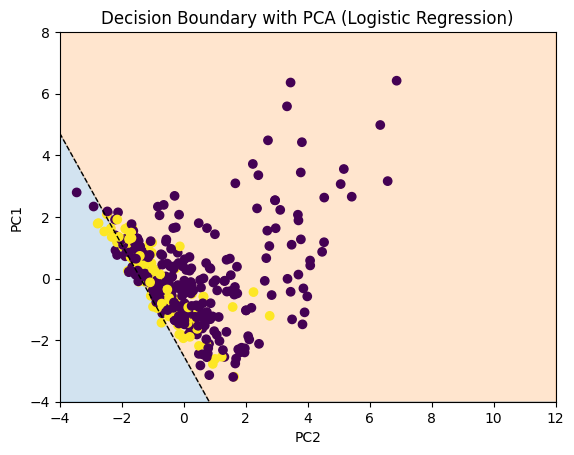

In [ ]:
# Fit the data to a logistic regression model.
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X_train_standardized_pca, y_train)
# Retrieve the model parameters.
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2
# Plot the data and the classification with the decision boundary.
xmin, xmax = -4, 12
ymin, ymax = -4, 8
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

my_plot=plt.scatter(X_train_standardized_pca[:, 0], X_train_standardized_pca[:, 1], c=y_train)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel('PC1')
plt.xlabel('PC2')
plt.title('Decision Boundary with PCA (Logistic Regression)')
plt.show()

(408, 2)
(408, 2)
(175, 2)
(175, 2)
Epoch [100/500], Loss: 0.5153
Epoch [200/500], Loss: 0.5021
Epoch [300/500], Loss: 0.4904
Epoch [400/500], Loss: 0.4777
Epoch [500/500], Loss: 0.4628


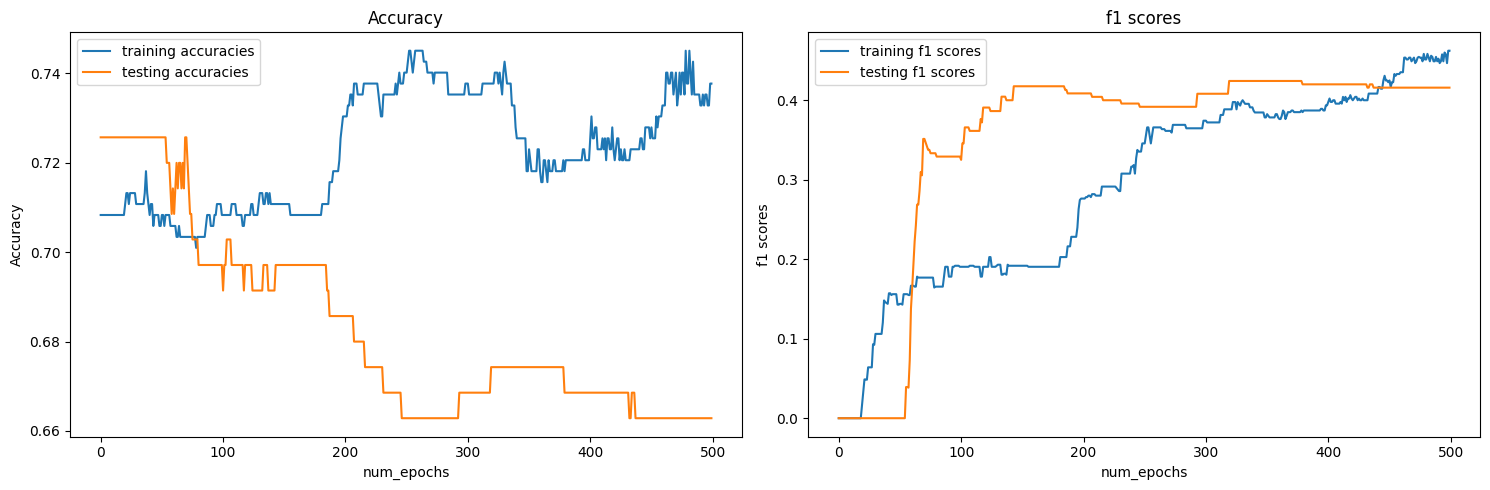

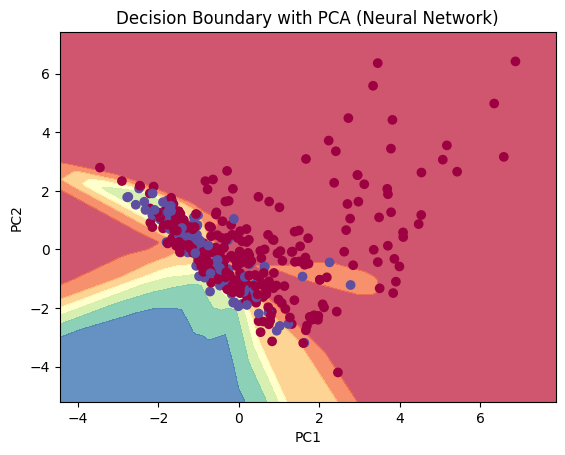

In [ ]:
from sklearn.neural_network import MLPClassifier
print(X_train_standardized_pca.shape)
print(X_train_standardized_pca.shape)
print(X_test_standardized_pca.shape)
print(X_test_standardized_pca.shape)
model_5e=train_and_test(best_architecture, 2, X_train_standardized_pca, y_train_normalized,
                     X_test_standardized_pca, y_test_normalized, 500)

#clf_nn = MLPClassifier(hidden_layer_sizes=list(best_architecture), max_iter=1000, random_state=42)
#clf_nn.fit(X_train_standardized_pca, y_train)


h = 0.02  # step size in the mesh
x_min, x_max = X_train_standardized_pca[:, 0].min() - 1, X_train_standardized_pca[:, 0].max() + 1
y_min, y_max = X_train_standardized_pca[:, 1].min() - 1, X_train_standardized_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model_5e(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.detach().numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_train_standardized_pca[:, 0], X_train_standardized_pca[:, 1], c=y_train, cmap=plt.cm.Spectral)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision Boundary with PCA (Neural Network)')
plt.show()

Both models have a testing accuracy around 0.70.


The decision boundary for Logistic Regression is a linear line and the decision boundary for Neural Network is a curve. From the graph, we can see that the curve fits better than the linear line.